In [1]:
from model import NSFrozenLake
from amalearn.agent import AgentBase
from draw_policy import draw_policy
from plots import plot_total_episode_rewards, plot_regret
from find_max_reward import find_max_reward

import matplotlib.pyplot as plt
import numpy as np

from CONFIG import *
EPISODES = 2000

In [2]:
class Agent(AgentBase):
    
    def __init__(self, id, environment, discount, epsilon, alpha, actions, episodes=1000, decade_lr=False):
        
        self.environment = environment
        self.i_limit, self.j_limit = 4, 4
        self.actions = actions
        self.epsilon = epsilon
        self.start_epsilon = epsilon
        self.alpha = alpha
        self.start_alpha = alpha
        self.decade_lr = decade_lr
        self.discount = discount
        self.episodes = episodes
        
        self.Q = {}
        self.init_Q()
        
        self.target_policy = {}
        self.b_policy = {}
        self.update_policies()
        
        super(Agent, self).__init__(id, environment)
        
    def init_Q(self):
        
        for i in range(self.i_limit):
            for j in range(self.j_limit):
                for a in self.actions:
                    if (i, j) == (3, 3):
                        self.Q[((i, j), a)] = 0
                    else:
                        self.Q[((i, j), a)] = np.random.rand()
                    
    def update_state_t_policy(self, state):
        
        state_qs = [self.Q[(state, a)] for a in self.actions]
        max_q_idx = np.argmax(state_qs)
        
        self.target_policy[state] = np.zeros(len(self.actions))
        self.target_policy[state][max_q_idx] = 1
        
    def update_state_b_policy(self, state):
        
        state_qs = [self.Q[(state, a)] for a in self.actions]
        max_q_idx = np.argmax(state_qs)
        
        self.b_policy[state] = np.zeros(len(self.actions))+(self.epsilon/len(self.actions))
        self.b_policy[state][max_q_idx] += (1-self.epsilon)
                    
    def update_policies(self):
        
        for i in range(self.i_limit):
            for j in range(self.j_limit):
                self.update_state_t_policy((i, j))
                self.update_state_b_policy((i, j))
                    
    def q_learning(self):
        
        total_rewards = []
        for epoch in range(REPS):
            
            self.reset()
            episode_rewards = []
            for e in range(self.episodes):
                
                rewards = []
                state = self.environment.reset()
                while True:
                    
                    action, next_state, reward, done = self.take_action(state)
                    rewards.append(reward)
                    
                    max_next_q = max([self.Q[(next_state, a)] for a in self.actions])
                    self.Q[(state, action)] += self.alpha*(reward+self.discount*max_next_q-self.Q[(state, action)])
                    self.update_state_b_policy(state)
                    state = next_state
                    
                    if done:
                        break
                
                episode_rewards.append(sum(rewards))
                
                if (e+1)%40 == 0:
                    self.epsilon *= 0.99
                if self.decade_lr and (e+1)%100 == 0:
                    self.alpha *= 0.95
                    
            self.environment.reset()
            total_rewards.append(episode_rewards)
            
        self.update_policies()
        
        return total_rewards
        
    def take_action(self, state):
        
        action = np.random.choice(self.actions, p=self.b_policy[state])
        next_state, reward, done, _ = self.environment.step(action)
        
        return action, next_state, reward, done
    
    def reset(self):
        
        self.init_Q()
        self.update_policies()
        self.epsilon = self.start_epsilon
        self.alpha = self.start_alpha

In [3]:
environment = NSFrozenLake(studentNum=STUDENT_NUM)
max_expected_reward = find_max_reward(environment)

In [4]:
agent = Agent('1', environment, DISCOUNT, EPSILON, LEARNING_RATE, ACTIONS, episodes=EPISODES)
rewards1 = agent.q_learning()

In [5]:
environment.render()
draw_policy(agent.target_policy)


------------------------------
| 0.000 | 0.001 | 0.332 | 0.746 | 
------------------------------
| 0.696 | 0.001 | 0.143 | 0.998 | 
------------------------------
| 0.703 | 0.001 | 0.001 | 0.001 | 
------------------------------
| 0.861 | 0.401 | 0.128 | 0.000 | 
------------------------------
→|↓|←|↑
→|↓|↓|↑
↑|→|→|↓
↑|→|→|↻


In [6]:
agent = Agent('1', environment, DISCOUNT, EPSILON, LEARNING_RATE, ACTIONS, episodes=EPISODES, decade_lr=True)
rewards2 = agent.q_learning()

In [7]:
environment.render()
draw_policy(agent.target_policy)


------------------------------
| 0.000 | 0.001 | 0.332 | 0.746 | 
------------------------------
| 0.696 | 0.001 | 0.143 | 0.998 | 
------------------------------
| 0.703 | 0.001 | 0.001 | 0.001 | 
------------------------------
| 0.861 | 0.401 | 0.128 | 0.000 | 
------------------------------
→|↓|←|←
↑|↓|↓|↑
→|→|→|↓
←|→|→|↻


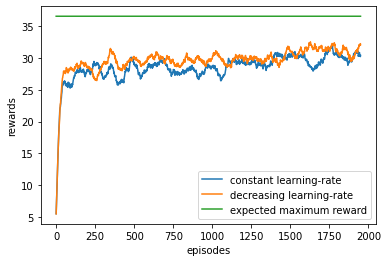

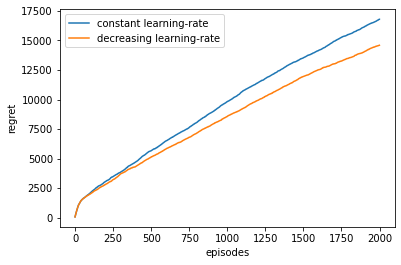

In [8]:
plot_total_episode_rewards(
    rewards1, rewards2, max_expected_reward, 
    'constant learning-rate', 'decreasing learning-rate', window_size=50
)
plot_regret(rewards1, rewards2, max_expected_reward, 'constant learning-rate', 'decreasing learning-rate')